# Step 1: Dataset Download, Extraction, and Initial Loading

In [ ]:
# Install necessary package if not already
!pip install kagglehub

# Import required libraries
import os
import pandas as pd
import zipfile
import kagglehub

# Step 1.1: Download the dataset using KaggleHub
dataset_path = kagglehub.dataset_download("kazanova/sentiment140")
print("Downloaded to:", dataset_path)

# Step 1.2: Extract the zip file if needed
for file in os.listdir(dataset_path):
    if file.endswith(".zip"):
        zip_path = os.path.join(dataset_path, file)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_path)
        print(f"Extracted contents of {zip_path}")

# Step 1.3: Load the CSV into a DataFrame
csv_file_path = os.path.join(dataset_path, "training.1600000.processed.noemoticon.csv")

# Load with correct encoding and no header
df = pd.read_csv(csv_file_path, encoding='latin-1', header=None)

# Assign proper column names
df.columns = ["target", "ids", "date", "flag", "user", "text"]

# Preview the data
print("Dataset shape:", df.shape)
print(df.head())


100%|██████████| 80.9M/80.9M [00:04<00:00, 17.6MB/s]

Extracting files...


Downloaded to: /root/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2
Dataset shape: (1600000, 6)
   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


 # Step 2: Data Exploration and Visualization

Shape of dataset: (1600000, 7)
Columns: Index(['target', 'ids', 'date', 'flag', 'user', 'text', 'sentiment'], dtype='object')
Null values:
 target       0
ids          0
date         0
flag         0
user         0
text         0
sentiment    0
dtype: int64
Duplicate rows: 0
Sentiment distribution:
 sentiment
Negative    800000
Positive    800000
Name: count, dtype: int64
Tweet length stats:
 count    1.600000e+06
mean     7.409011e+01
std      3.644114e+01
min      6.000000e+00
25%      4.400000e+01
50%      6.900000e+01
75%      1.040000e+02
max      3.740000e+02
Name: text_length, dtype: float64


/tmp/ipython-input-2816867526.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='pastel')


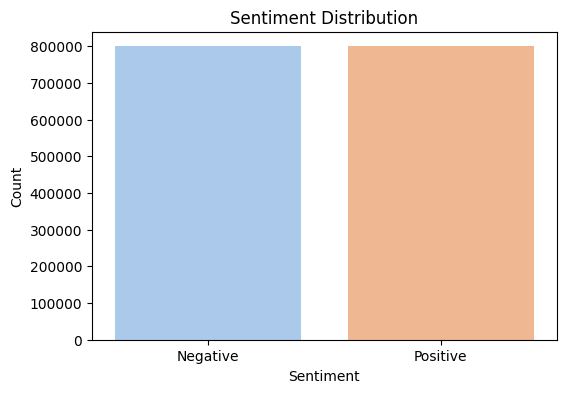

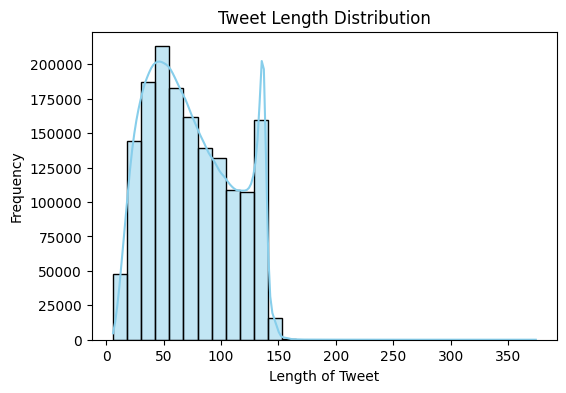

In [ ]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Map sentiment labels for clarity
df['sentiment'] = df['target'].map({0: 'Negative', 2: 'Neutral', 4: 'Positive'})

# ===== Data Exploration =====

# Basic stats
print("Shape of dataset:", df.shape)
print("Columns:", df.columns)
print("Null values:\n", df.isnull().sum())
print("Duplicate rows:", df.duplicated().sum())
print("Sentiment distribution:\n", df['sentiment'].value_counts())

# Tweet length analysis
df['text_length'] = df['text'].apply(len)
print("Tweet length stats:\n", df['text_length'].describe())

# ===== Visualizations =====

# Sentiment distribution plot
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df, palette='pastel')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Tweet length distribution
plt.figure(figsize=(6,4))
sns.histplot(df['text_length'], bins=30, kde=True, color='skyblue')
plt.title("Tweet Length Distribution")
plt.xlabel("Length of Tweet")
plt.ylabel("Frequency")
plt.show()

# ===== Preprocessing Example =====

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)


# Step 3: Feature Extraction (for ML and DL pipelines)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Define features and labels
X = df['clean_text']
y = df['target']  # Use numeric labels: 0 = negative, 2 = neutral, 4 = positive

# Split the data for both ML and DL workflows (stratify ensures balanced class representation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ================================
# For Traditional ML Models (SVM, Naïve Bayes): Use TF-IDF
# ================================

tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# ================================
# For Deep Learning Models (CNN–LSTM): Use Tokenizer + Padding
# ================================

# Define tokenizer settings
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure equal length input
max_len = 50  # based on tweet length distribution
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Convert labels to numpy arrays for DL
y_train_array = np.array(y_train)
y_test_array = np.array(y_test)


# Step 4: Traditional Machine Learning Training and Evaluation

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Train Naïve Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_preds = nb_model.predict(X_test_tfidf)

# Train Support Vector Machine model
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
svm_preds = svm_model.predict(X_test_tfidf)

# =====================
# Evaluation Function
# =====================
def evaluate_model(true_labels, predictions, model_name):
    # Identify unique sorted labels in test data
    unique_labels = sorted(list(set(true_labels) | set(predictions)))

    # Map available label integers to sentiment class names
    label_map = {0: 'Negative', 2: 'Neutral', 4: 'Positive'}
    target_names = [label_map[label] for label in unique_labels]

    # Classification Report
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(true_labels, predictions, target_names=target_names))

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions, labels=unique_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

    plt.figure(figsize=(6, 5))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.grid(False)
    plt.show()




Classification Report for Multinomial Naïve Bayes:

              precision    recall  f1-score   support

    Negative       0.78      0.79      0.78    160000
    Positive       0.79      0.77      0.78    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



<Figure size 600x500 with 0 Axes>

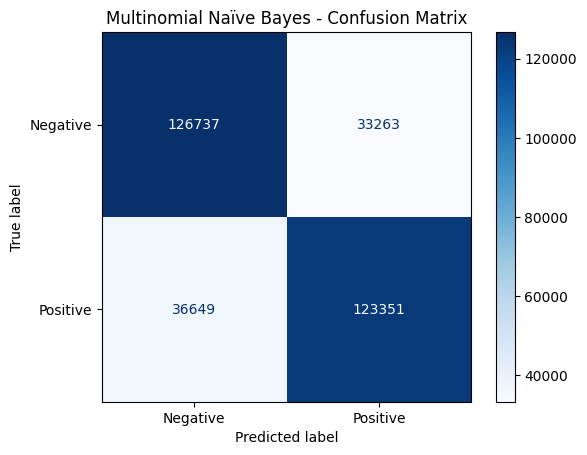


Classification Report for Linear SVM:

              precision    recall  f1-score   support

    Negative       0.82      0.79      0.80    160000
    Positive       0.79      0.82      0.81    160000

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



<Figure size 600x500 with 0 Axes>

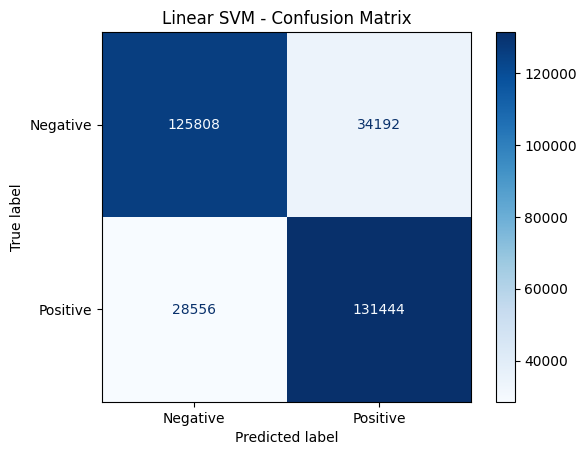

In [ ]:
# Call the function to evaluate your models

# For Naïve Bayes
evaluate_model(y_test, nb_preds, "Multinomial Naïve Bayes")

# For SVM
evaluate_model(y_test, svm_preds, "Linear SVM")


# Step 5: CNN–LSTM Hybrid Model for Sentiment Classification

# 5.1. Preprocessing & Encoding


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Keep only required columns
df_model = df[['text', 'target']].copy()

# Ensure only valid labels (0, 2, 4)
df_model = df_model[df_model['target'].isin([0, 2, 4])]

# Encode labels: 0 → 0, 2 → 1, 4 → 2
label_encoder = LabelEncoder()
df_model['target'] = label_encoder.fit_transform(df_model['target'])  # 0,1,2

# Text and labels
X = df_model['text']
y = to_categorical(df_model['target'], num_classes=3)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#  5.2. Tokenization and Padding

In [ ]:
# Tokenizer
vocab_size = 20000
max_len = 50

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


#  5.3. CNN–LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

embedding_dim = 100

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 sentiment classes

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#  5.4. Model Training

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# ========== 💻 Check GPU Availability ==========
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        print(f"✅ GPU Detected: {gpus[0].name}")
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(f"⚠️ GPU memory growth error: {e}")
else:
    print("❌ No GPU found. Using CPU instead.")

# ========== ⏳ Training Configuration ==========
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# ========== 🚀 Train Model on GPU ==========
history = model.fit(
    X_train_pad,
    y_train,
    epochs=30,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)


✅ GPU Detected: /physical_device:GPU:0
⚠️ GPU memory growth error: Physical devices cannot be modified after being initialized
Epoch 1/30
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.8591 - loss: 0.3254 - val_accuracy: 0.8263 - val_loss: 0.3881
Epoch 2/30
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.8756 - loss: 0.2925 - val_accuracy: 0.8238 - val_loss: 0.3992
Epoch 3/30
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.8924 - loss: 0.2573 - val_accuracy: 0.8205 - val_loss: 0.4337
Epoch 4/30
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.9072 - loss: 0.2252 - val_accuracy: 0.8126 - val_loss: 0.4635
Epoch 5/30
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.9199 - loss: 0.1966 - val_accuracy: 0.8097 - val_loss: 0.5522
Epoch 6/30
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.9284 - loss: 0.1768 - val_accuracy: 0.8062 - val_loss: 0.5702
Epoch 7/30
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.9353 - loss: 0.159

# 5.5 Training Curves

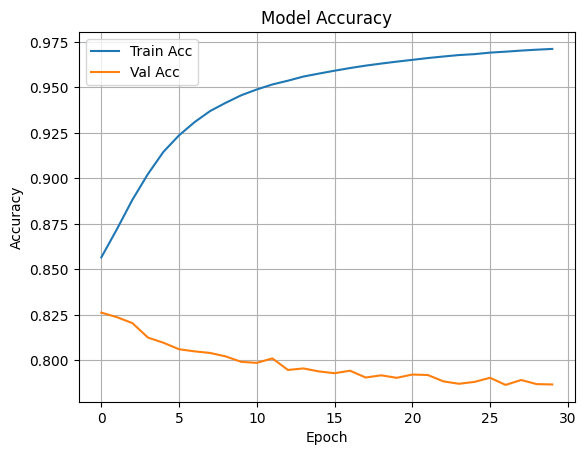

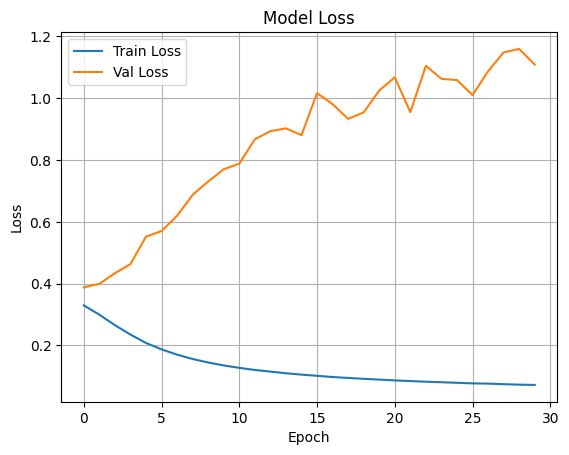

In [ ]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# 5.6. Evaluation

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
📊 Final Classification Report (CNN–LSTM):
              precision    recall  f1-score   support

    Negative       0.78      0.80      0.79    159494
     Neutral       0.80      0.77      0.78    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



<Figure size 600x500 with 0 Axes>

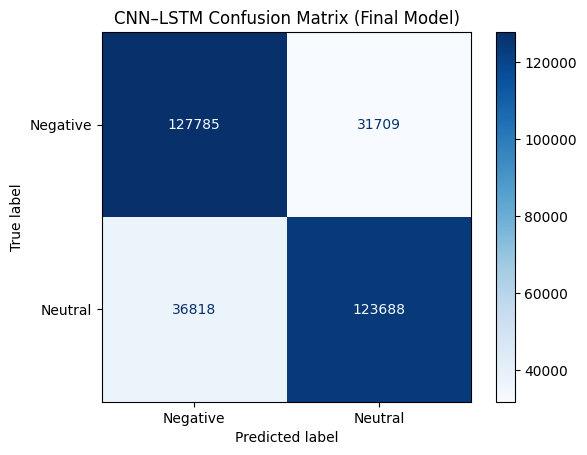

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1️⃣ Generate Predictions
y_pred_prob = model.predict(X_test_pad, batch_size=128, verbose=1)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 2️⃣ Generate Classification Report
# Define label mapping for display
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

# Ensure only the classes present are used
unique_classes = sorted(np.unique(np.concatenate([y_true_classes, y_pred_classes])))
target_names = [label_map[i] for i in unique_classes]

print("📊 Final Classification Report (CNN–LSTM):")
print(classification_report(
    y_true_classes,
    y_pred_classes,
    labels=unique_classes,
    target_names=target_names
))

# 3️⃣ Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes, labels=unique_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("CNN–LSTM Confusion Matrix (Final Model)")
plt.grid(False)
plt.show()


Label counts: Counter({0: 800000, 4: 800000})
Train/Val/Test sizes: 1280000, 160000, 160000


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 53s 10ms/step - accuracy: 0.7896 - loss: 0.4436 - val_accuracy: 0.8285 - val_loss: 0.3814 - learning_rate: 0.0010
Epoch 2/12
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.8415 - loss: 0.3586 - val_accuracy: 0.8306 - val_loss: 0.3842 - learning_rate: 0.0010
Epoch 3/12
4998/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8667 - loss: 0.3104
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.8667 - loss: 0.3104 - val_accuracy: 0.8232 - val_loss: 0.4324 - learning_rate: 0.0010
Epoch 4/12
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.8948 - loss: 0.2513 - val_accuracy: 0.8145 - val_loss: 0.5791 - learning_rate: 5.0000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


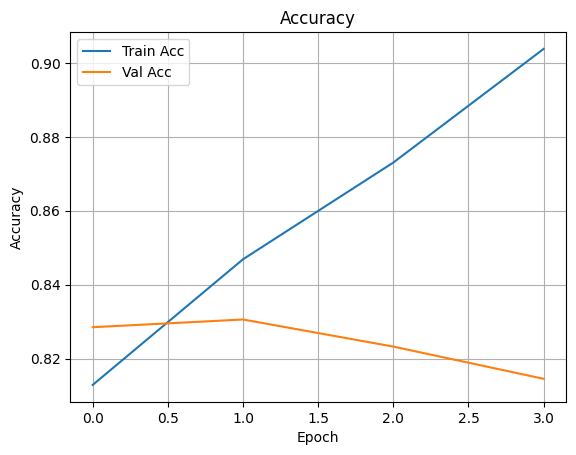

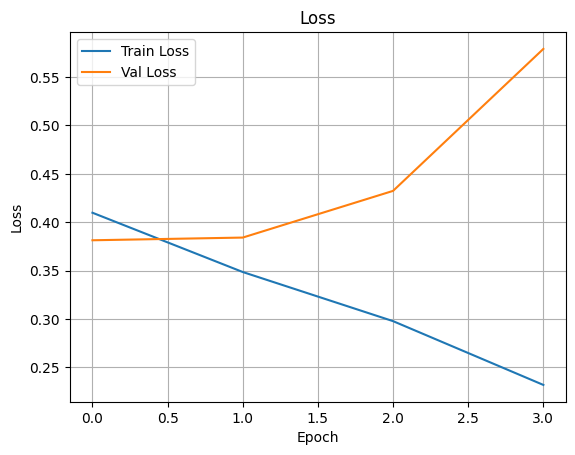

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

=== Classification Report (CNN–BiLSTM) ===
              precision    recall  f1-score   support

    Negative     0.8407    0.8131    0.8267     80000
    Positive     0.8190    0.8459    0.8322     80000

    accuracy                         0.8295    160000
   macro avg     0.8299    0.8295    0.8295    160000
weighted avg     0.8299    0.8295    0.8295    160000



<Figure size 600x500 with 0 Axes>

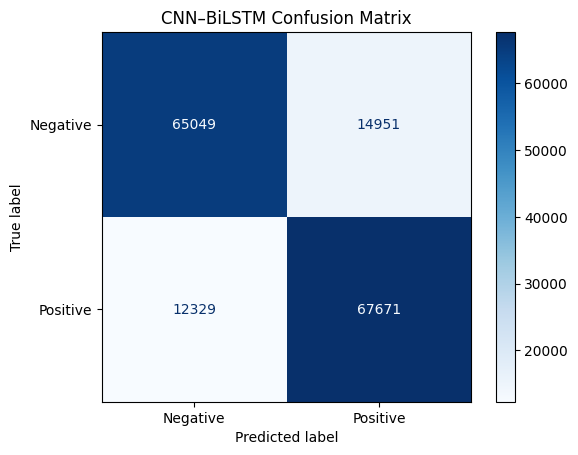

In [3]:
# =========================
# 0) Setup
# =========================
!pip -q install kagglehub==0.3.12

import os, re, zipfile, yaml, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# =========================
# 1) Load Sentiment140
# =========================
dataset_path = kagglehub.dataset_download("kazanova/sentiment140")
for file in os.listdir(dataset_path):
    if file.endswith(".zip"):
        with zipfile.ZipFile(os.path.join(dataset_path, file), "r") as z:
            z.extractall(dataset_path)

csv_path = os.path.join(dataset_path, "training.1600000.processed.noemoticon.csv")
df = pd.read_csv(csv_path, encoding="latin-1", header=None,
                 names=["target","ids","date","flag","user","text"])

# Keep only the columns we need
df = df[["target","text"]].copy()

# NOTE:
# Raw Sentiment140 has only 0 (negative) and 4 (positive).
# If you already added Neutral (2) elsewhere, this pipeline will include it automatically.
valid_labels = {0,2,4}
df = df[df["target"].isin(valid_labels)].copy()

# (Optional) Downsample for faster demos; comment this out for full training
# df = df.groupby("target", group_keys=False).apply(lambda x: x.sample(min(len(x), 120_000), random_state=SEED))

print("Label counts:", Counter(df["target"]))

# =========================
# 2) Minimal text cleaning
# =========================
def clean_tweet(t):
    t = t.lower()
    t = re.sub(r"http\S+|www\.\S+", " URL ", t)
    t = re.sub(r"@\w+", " USER ", t)
    t = re.sub(r"#(\w+)", r"\1", t)   # keep hashtag word
    t = re.sub(r"&amp;", " and ", t)
    t = re.sub(r"[^a-z0-9\s'!?.,]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

df["clean_text"] = df["text"].astype(str).apply(clean_tweet)

# =========================
# 3) Stable label mapping
# =========================
# We build an explicit ordered class list based on what actually exists in df.
present = sorted(df["target"].unique())          # e.g., [0,4] or [0,2,4]
class_id_map = {lab:i for i, lab in enumerate(present)}   # e.g., {0:0, 4:1}
id_class_map = {i:lab for lab,i in class_id_map.items()}

# Human-readable names tied to ORIGINAL labels:
name_for_label = {0: "Negative", 2: "Neutral", 4: "Positive"}
class_names = [name_for_label[lab] for lab in present]

df["y_idx"] = df["target"].map(class_id_map)

# =========================
# 4) Train/Val/Test split
# =========================
X_train, X_temp, y_train, y_temp = train_test_split(
    df["clean_text"], df["y_idx"],
    test_size=0.20, random_state=SEED, stratify=df["y_idx"]
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50, random_state=SEED, stratify=y_temp
)
print(f"Train/Val/Test sizes: {len(X_train)}, {len(X_val)}, {len(X_test)}")

num_classes = len(present)

# =========================
# 5) Tokenize & pad
# =========================
vocab_size = 40_000
max_len = 50

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post", truncating="post")
X_val_pad   = pad_sequences(X_val_seq,   maxlen=max_len, padding="post", truncating="post")
X_test_pad  = pad_sequences(X_test_seq,  maxlen=max_len, padding="post", truncating="post")

y_train_cat = to_categorical(np.array(y_train), num_classes=num_classes)
y_val_cat   = to_categorical(np.array(y_val),   num_classes=num_classes)
y_test_cat  = to_categorical(np.array(y_test),  num_classes=num_classes)

# =========================
# 6) Build CNN–BiLSTM model
# =========================
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Conv1D(filters=128, kernel_size=3, activation="relu", padding="same"),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(96, return_sequences=False)),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

# =========================
# 7) Train
# =========================
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
reduce_lr  = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

history = model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_val_pad, y_val_cat),
    epochs=12,
    batch_size=256,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# =========================
# 8) Learning curves
# =========================
plt.figure()
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy"); plt.legend(); plt.grid(True)
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss"); plt.legend(); plt.grid(True)
plt.show()

# =========================
# 9) Evaluation: report + confusion matrix (correct labels)
# =========================
y_prob = model.predict(X_test_pad, batch_size=512, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.array(y_test)

print("\n=== Classification Report (CNN–BiLSTM) ===")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(6,5))
disp.plot(cmap="Blues", values_format="d", colorbar=True)
plt.title("CNN–BiLSTM Confusion Matrix")
plt.grid(False)
plt.show()



Macro ROC–AUC: 0.9111


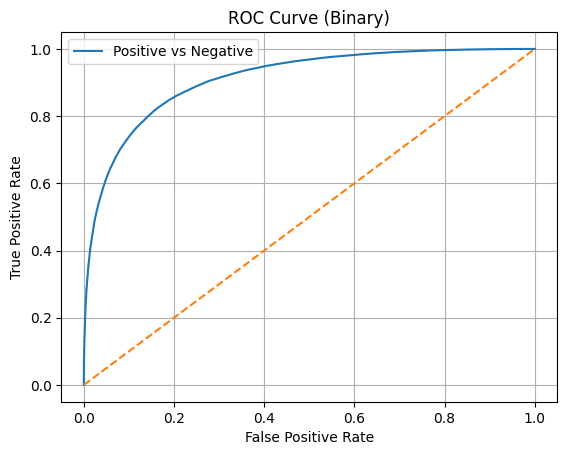

In [4]:
# =========================
# 10) ROC–AUC (one-vs-rest, macro)
# =========================
from sklearn.preprocessing import label_binarize

if num_classes == 2:
    # Binary classification
    auc_macro = roc_auc_score(y_true, y_prob[:, 1])  # prob for positive class
    print(f"Macro ROC–AUC: {auc_macro:.4f}")

    # ROC curve for the positive class only
    fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label="Positive vs Negative")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Binary)")
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    # Multiclass (one-vs-rest)
    auc_macro = roc_auc_score(y_true, y_prob, average="macro", multi_class="ovr")
    print(f"Macro ROC–AUC: {auc_macro:.4f}")

    # Binarize y_true for plotting one-vs-rest ROC
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

    plt.figure()
    for i, cname in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, label=cname)
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("One-vs-Rest ROC Curves (Multiclass)")
    plt.legend()
    plt.grid(True)
    plt.show()


#  Step 6: Explainability Using SHAP and LIME

# 6.1. Install LIME

In [ ]:
!pip install lime shap --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


#  6.2. TF-IDF Feature Extraction

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use the same X_train and X_test from earlier preprocessing
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# 6.3. Encode Targets for Traditional ML (Class Labels)

In [ ]:
# We already used one-hot for DL — revert to integer labels here
import numpy as np
y_train_class = np.argmax(y_train, axis=1)
y_test_class = np.argmax(y_test, axis=1)


# 6.4. Train Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_tfidf, y_train_class)


LogisticRegression(max_iter=1000)

# 6.5. Create Pipeline for LIME

In [ ]:
from sklearn.pipeline import make_pipeline

logreg_pipeline = make_pipeline(tfidf_vectorizer, logreg_model)


# 6.6. LIME Text Explainability

In [ ]:
from lime.lime_text import LimeTextExplainer

# Define target names (must match your encoded classes)
target_names = ['Negative', 'Neutral', 'Positive']

# Create LIME explainer
explainer = LimeTextExplainer(class_names=target_names)

# Pick a test example
i = 42  # You can change index
sample_text = X_test.iloc[i]
actual_class = y_test_class[i]

print(f"Text:\n{sample_text}")
print(f"Actual Label: {target_names[actual_class]}")

# Run LIME explanation
exp = explainer.explain_instance(
    sample_text,
    logreg_pipeline.predict_proba,
    num_features=10
)

# Show explanation
exp.show_in_notebook(text=sample_text)  # In Jupyter


Text:
@foprof LOL.  Leave a kid on internet and the kid will do stupid things.
Actual Label: Neutral


# Save the model architecture and weights in HDF5 format

In [5]:
import pickle

# =========================
# 11) Save Model & Tokenizer
# =========================

# 1. Save trained model in HDF5 format
model.save("cnn_lstm_sentiment_model.h5")
print("✅ Model saved as cnn_lstm_sentiment_model.h5")

# 2. Save fitted tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("✅ Tokenizer saved as tokenizer.pkl")


✅ Model saved as cnn_lstm_sentiment_model.h5
✅ Tokenizer saved as tokenizer.pkl
